### [筆記來源](https://colab.research.google.com/drive/15Cyy2H7nT40sGR7TBN5wBvgTd57mVKay#forceEdit=true&sandboxMode=true)

#### Machine Learning 有四個重要的演算法，這篇文章講 Linear Regression:
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

#### 做二維 linear regression 時，我們其實希望線的左右兩邊有一樣的點。
#### 而 linear regression 也不限於二維，通常的情況是有多維的資料(x, y, z, w...)進入，產出一個結果(m)。
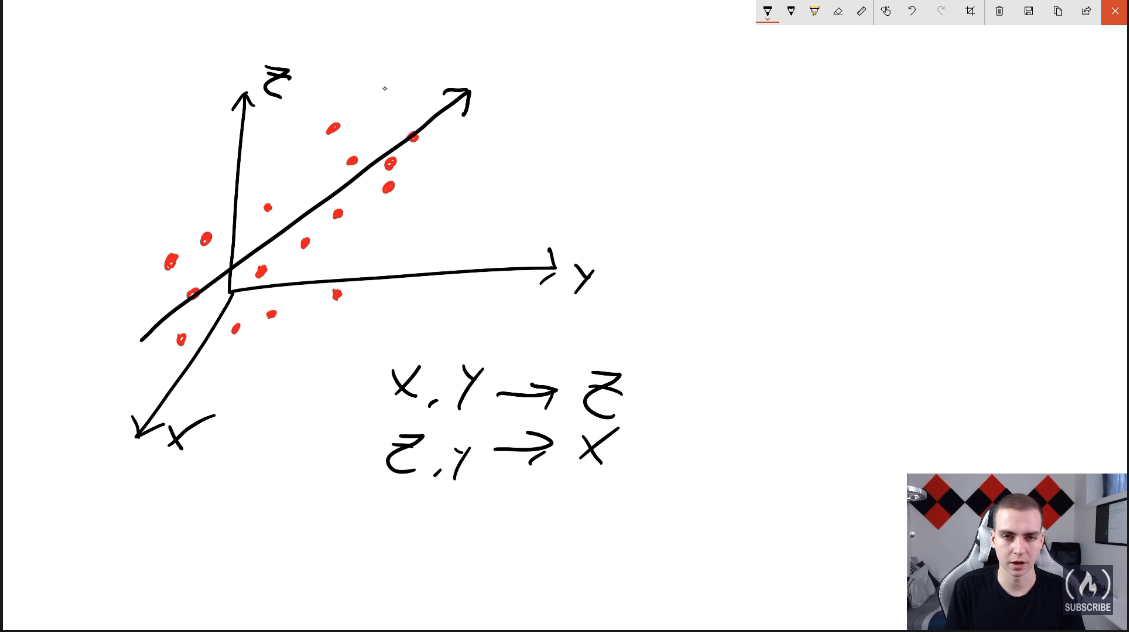

## 做一套完整的 Machine Learning 步驟:
    1. Import necessary packages
    2. Import the data set
    3. Explore the data set
    4. Adjust the data set to numerical
    5. Feed the data from data set (input function)
    6. Create a model

In [1]:
# 開始打 code 吧:
!pip install -q sklearn

#### numpy 適合對多個維度的 array 做計算。

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

#### 安裝好可能會用到的套件後，就拿一個 data 來看看吧。
##### 檔案是關於鐵達尼號乘客的存活狀況(1代表生存，0 代表死亡)
##### <font color='green'>我們可以預想，如果是女人或小孩，存活的機率可能大一些</font>
##### 這就非常適合用 linear regression。
---

#### y_train 是我們要給電腦學習的資料(但我們要先把答案藏起來，不然怎麼叫學?)
#### y_eval 則是我們準備拿來考電腦的資料(也是要先把答案藏起來)
#### 用 <font color='blue'> 用 df.pop() 可以將第一個 column 拆出來 </font>

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

print(dftrain.head())
y_train = dftrain.pop('survived')
print()
print(y_train.head()) # 這時 y_train 就是被你 pop 出來的 column(這叫 Series)

y_eval = dfeval.pop('survived')

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [4]:
print(dftrain.shape) # 627 entries and 9 features

(627, 9)


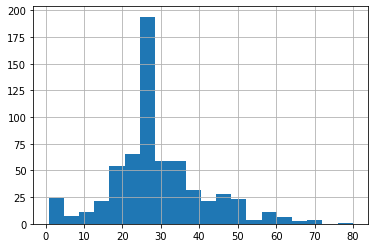

In [5]:
dftrain.age.hist(bins = 20) # hist stands for histrogram

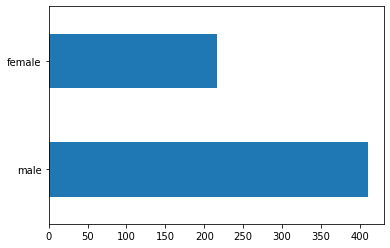

In [6]:
dftrain.sex.value_counts().plot(kind='barh') # value_counts() 會把性別資料分類，並分別總計

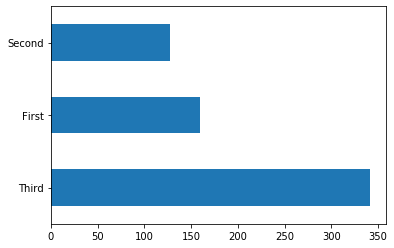

In [7]:
dftrain['class'].value_counts().plot(kind='barh') # 如上，這次用艙等分類

Text(0.5, 0, '% survive')

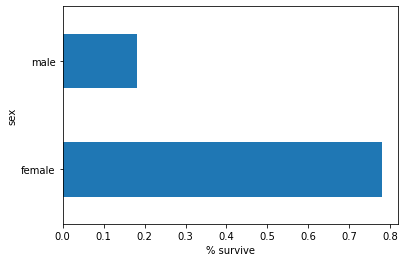

In [8]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
# axis = 1 為橫向合併[左右方向堆疊]

#### 運用 matplotlib 得到的圖表，我們發現:
- 登船的男人比女人多
- 最多人選三等艙，其次是一等艙，最少人的是二等艙
- 女性存活的機率比男性存活的機率高出非常多

#### 在我們把資料給電腦學習之前，我們必須把 <font color='red'>categorical data 轉換為 numerical data </font>。  
#### 像是 age，fare(票價) 等都是 numerical data。  
#### 而 sex，deck，embark_town 等都是 categorical data。
---
#### 因此創兩個 list，一個放 categorical 的 column，另一個放 numerical 的 column  
#### 而目標是將兩個 list 的 columns 都轉成 numerical，並合併到 feature_columns

In [9]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

#### 可以用 <font color='blue'> .unique() </font> 來看某 column 有哪些獨特的 data:

In [10]:
dftrain['age'].unique()

array([22.  , 38.  , 26.  , 35.  , 28.  ,  2.  , 27.  , 14.  ,  4.  ,
       20.  , 39.  , 31.  , 19.  , 40.  , 66.  , 42.  ,  3.  , 18.  ,
        7.  , 49.  , 29.  , 65.  , 21.  , 28.5 , 11.  , 45.  , 17.  ,
       32.  , 25.  ,  0.83, 30.  , 16.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 34.  , 33.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 ,  9.  ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 50.  , 36.  , 58.  , 20.5 ,
       41.  , 63.  , 43.  , 61.  , 15.  , 60.  , 64.  ,  5.  , 52.  ,
       48.  , 56.  ,  0.75, 54.  , 62.  , 53.  , 57.  , 80.  ,  6.  ,
       70.  , 30.5 , 10.  , 34.5 ])

In [11]:
type(dftrain['age'].unique())

numpy.ndarray

#### 接著，我們就可以用 .unique()，把每個獨特值(主要是 categorical data)分配給一個數字:
##### TensorFlow 提供了兩個好用的 methods:
- For categorical data: <font color='red'> tf.feature_column.categorical_column_with_vocabulary_list(某 categorical data column,unique value)</font>
- For numerical data: <font color='red'> tf.feature_column.numeric_column(某 numerical data column, numerical data 的 data type) </font>

In [12]:
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [13]:
type(feature_columns)

list

#### 確定都是 numerical data 後，下一步就是 <font color='red'>create the model!</font>
---
#### 問題是，給電腦學習的 dataset 通常都很大，我們的 RAM 無法一次吃那麼多資料。
##### 因此我們應該給 <font color='green'>batch(批量)</font>，也就是分批把資料丟進，一次丟固定的數量。那 batch 又是怎麼決定的呢?
###### 那就要看 <font color='green'>epoch(時代?)</font>了。所謂 epoch，就是<font color='red'>要讓電腦重複看一樣的 dataset 幾次</font>。

#### 而所謂的 <font color='green'> overfitting </font>，就是電腦看太多次一樣的 dataset，讓他對 training data 很熟悉，但一給他新資料(testing data)，他就不會了。  
---
#### 解決一次丟入太多 data 的問題後，下一步是將 dataset(還記得嗎，是 <font color='red'>DataFrame</font>) 轉換成 TensorFlow 指定的物件(<font color='red'>tf.data.Dataset</font>)。
#### 為此，我們必須定義一個 <font color='green'>input function</font>。

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset

  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) # epochs 設為 1 並且不用 shuffle，因為這是給電腦的考試題

#### 別忘記 label 就是答案
#### <font color='blue'>.tf.data.Dataset.from_tensor_slices(轉成字典的 features, DataFrame 型態的 label)</font>
##### [別忘記 DataFrame 就是從字典來的!](https://nbviewer.jupyter.org/github/LLH07/Python_pandas/blob/master/CH%202%20Data%20Frame%20%E8%88%87%20Python.ipynb)
#### [Decorator Function 複習](https://github.com/LLH07/python_tutorial/blob/master/Decorator/decorator.py)
#### [關於 shuffle，batch，與 repeat](https://blog.csdn.net/googler_offer/article/details/89929657)

### 做好 input function，終於可以訓練了!
#### <font color='blue'>tf.estimator.LinearClassifier(feature_columns = []) </font>

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmp2co2lxyb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027398E952E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
linear_est.train(train_input_fn) 

result = linear_est.evaluate(eval_input_fn)  

clear_output()  # clears console output(在跑時會有一大串東西)

print(result['accuracy'])  
print(result)

0.7765151
{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.84031224, 'auc_precision_recall': 0.7961744, 'average_loss': 0.47096598, 'label/mean': 0.375, 'loss': 13.815002, 'precision': 0.6923077, 'prediction/mean': 0.40765238, 'recall': 0.72727275, 'global_step': 400}


#### 成功套用模型了!
- <font color='green'> .train(<font color='blue'> 上一步的 input function[for train] </font>) </font>
- <font color='green'> .evaluate(<font color='blue'> 上一步的 input function [for evaluate] </font>) </font>
- result variable 是一個 <font color='green'> 存放模型各種統計資料的字典 </font>。

In [23]:
result = list(linear_est.predict(eval_input_fn)) # list 的每個 element 就是每次 predict 的各種統計結果的 dictionary
clear_output()
# print(result) # 這是 predict 所有 evalute 的資料，總共大小就是你給的 evalute 資料數。

print(len(result))
print(result[0]) # 這是 predict 第一個資料的結果。

264
{'logits': array([-2.5496159], dtype=float32), 'logistic': array([0.07245231], dtype=float32), 'probabilities': array([0.92754775, 0.07245229], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1]), 'all_classes': array([b'0', b'1'], dtype=object)}


In [25]:
result2 = linear_est.predict(eval_input_fn)
clear_output()
print(type(result2))

<class 'generator'>
